# [Demo] Identification of the $\pi$ pulse

$\newcommand{\ket}[1]{|#1\rangle}$
$\newcommand{\bra}[1]{\langle#1|}$
$\newcommand{\ketbra}[2]{| #1 \rangle\langle #2 |}$

In [1]:
import os
import copy
import logging
import numpy as np
import scipy.optimize as sciopt
from scipy.fft import fft
import matplotlib.pyplot as plt
import rqutils.paulis as paulis
import qudit_sim

try:
    os.mkdir('pi_pulse')
except FileExistsError:
    pass

## System Hamiltonian

We will run the simulations in the ququadrit space and extract qutrit operators from the results.

In [2]:
hgen = qudit_sim.HamiltonianBuilder(4)
hgen.add_qudit(qubit_frequency=3.e+10, anharmonicity=-2.e+9, drive_amplitude=1.5e+9, qudit_id='q0')

## Effective Hamiltonian of a qubit-resonant drive

First we apply a constant drive and identify which terms are present in the ququadrit effective Hamiltonian. Here we cheat a bit and fix the nonresonant X and Y terms a priori (that they should be zero is obvious after looking at the generator evolution).

In [3]:
drive_frequency_01 = hgen.dressed_frequencies('q0')[0]
test_amplitude = 0.2

init = dict((i, (0., True)) for i in [4, 5, 6, 7, 13, 14])

res01_components = qudit_sim.apps.find_heff(hgen, qudit='q0', frequency=drive_frequency_01, amplitude=test_amplitude,
                                            cycles=200, optimizer_args=0.001, convergence=1.e-6, comp_dim=3,
                                            init=init, save_result_to='pi_pulse/res01')

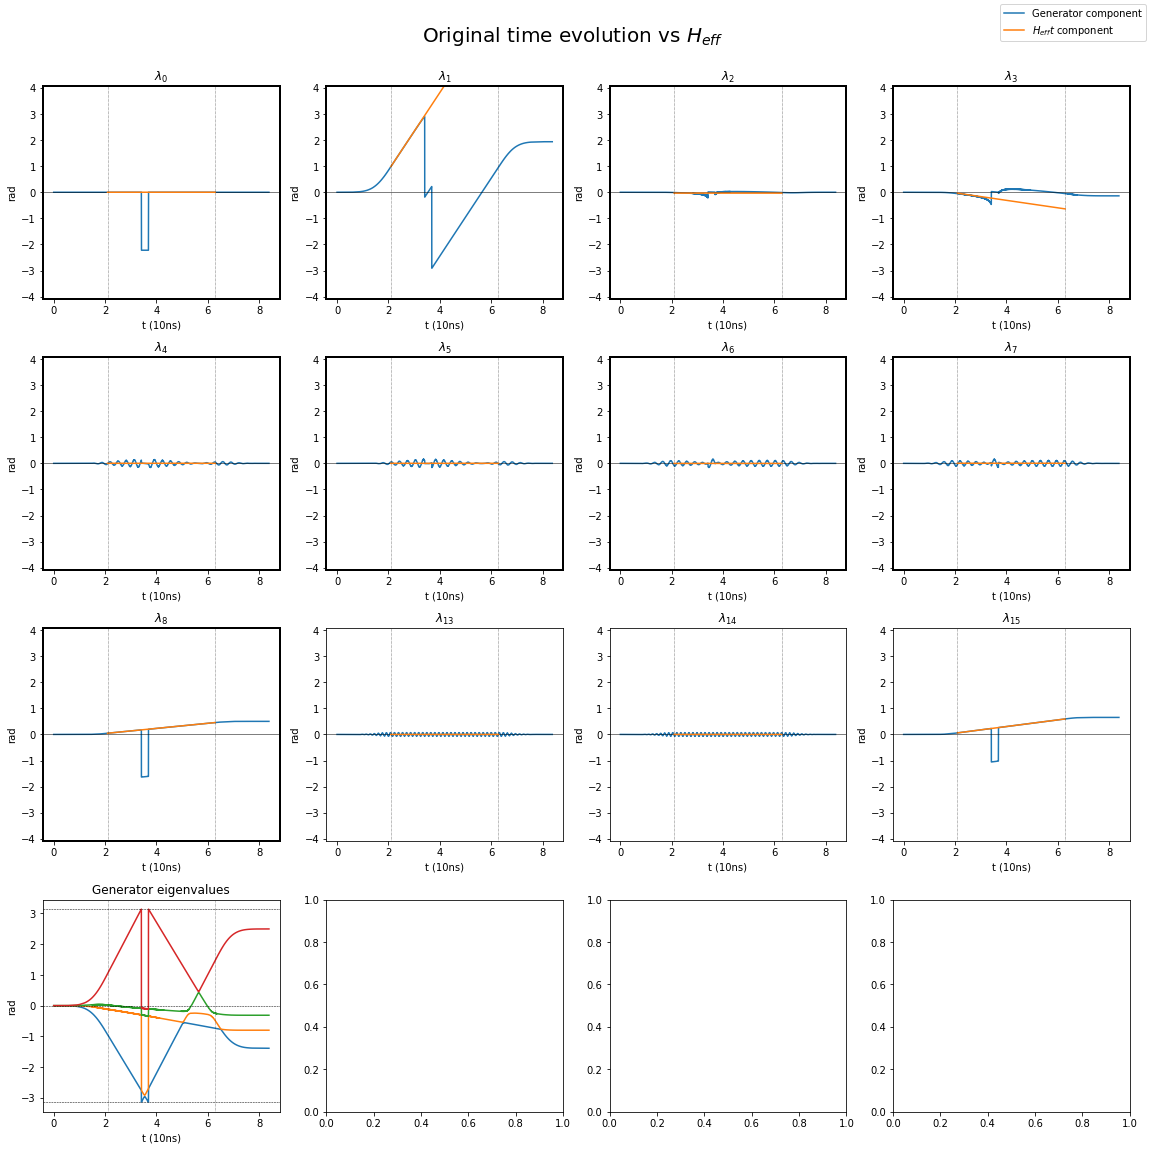

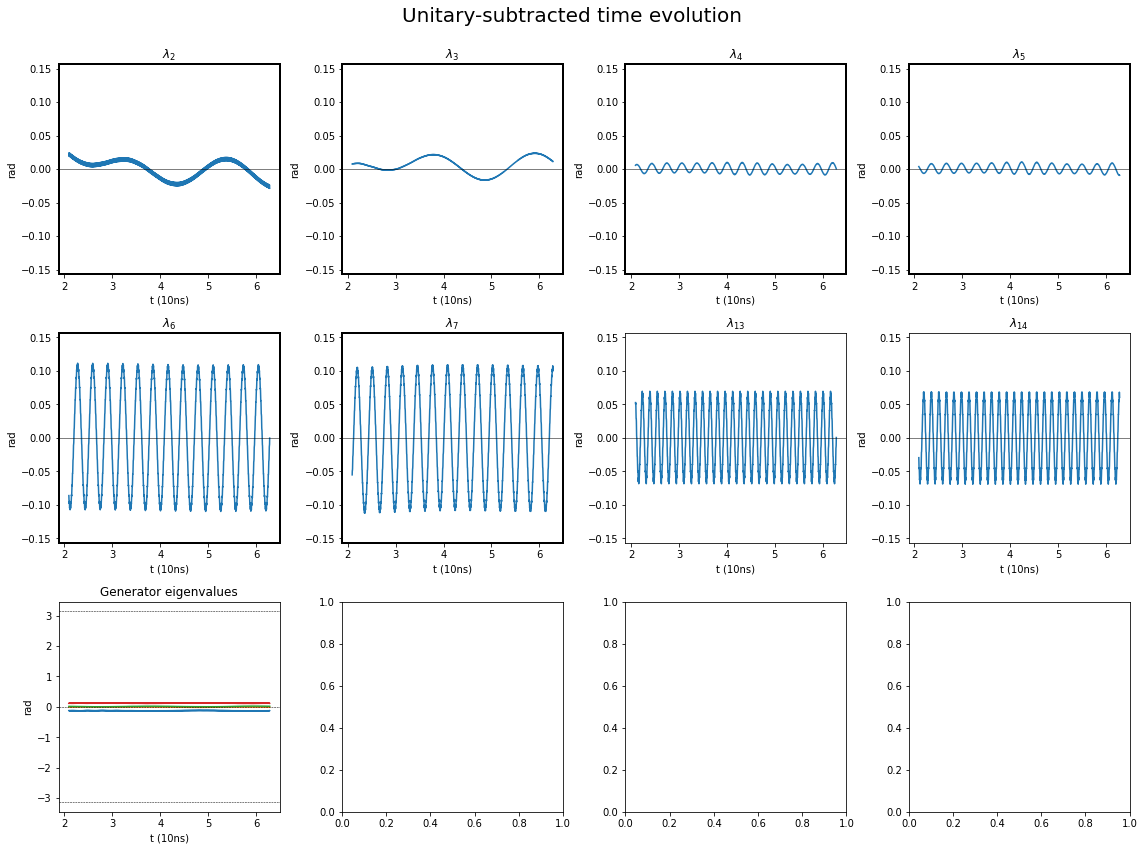

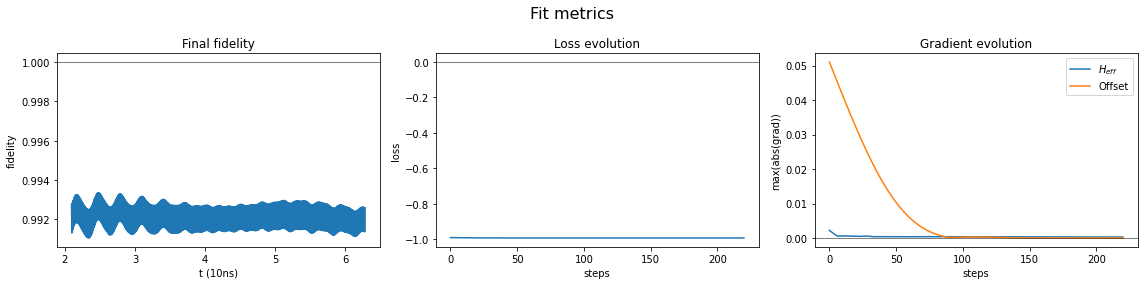

In [4]:
qudit_sim.visualization.inspect_heff_fit('pi_pulse/res01.h5');

In [5]:
qudit_sim.visualization.print_components(res01_components, threshold=-0.01)

<IPython.core.display.Latex object>

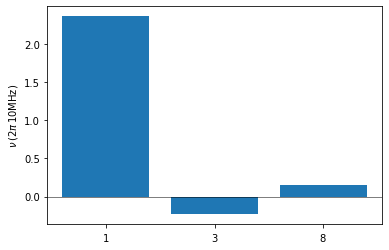

In [6]:
qudit_sim.visualization.plot_components(res01_components, threshold=-0.01);

In addition to the $\lambda_1$ that generates the $R_x$ rotation, we have diagonal terms from AC Stark effects. The qubit-space diagonal $\lambda_3$ is mostly due to the AC Stark shifts of $\ket{1}\leftrightarrow\ket{2}$ and $\ket{2}\leftrightarrow\ket{3}$ transitions, but even when interpreted in the qudit basis, there is a small $Z_{01}$ generated from induced transitions such as $\ket{0}\leftrightarrow\ket{2}$.

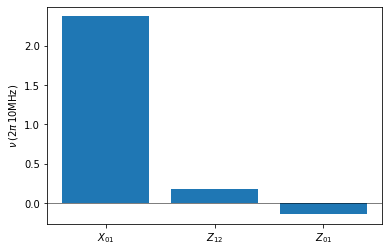

In [7]:
qudit_sim.visualization.plot_components(res01_components, threshold=-0.01, basis='qudit');

## Gaussian pulse

We will ultimately find a DRAG pulse to implement $R_x(\pi)$, but we start with a Gaussian with a fixed duration and find the amplitude that gets us close to $\pi$.

In [8]:
hgen.clear_drive()

unit_time = 0.2e-9

duration_01 = unit_time * 160
sigma_01 = unit_time * 40

This pulse has a line width of $1/\sigma = 125 \mathrm{Mrad/s}$ in the frequency domain, which means that the $\ket{1}\leftrightarrow\ket{2}$ transition frequency is 16 sigmas away.

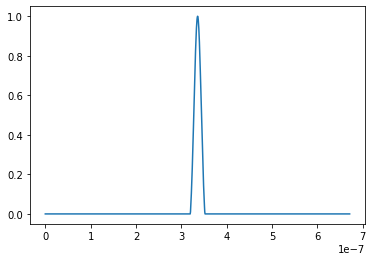

In [9]:
pulse_seq = qudit_sim.pulse.PulseSequence([
    qudit_sim.pulse.Delay(duration_01 * 10.),
    qudit_sim.pulse.Gaussian(duration=duration_01, amp=1., sigma=sigma_01),
    qudit_sim.pulse.Delay(duration_01 * 10.)
])

num_samples = 2**10

tpoints = np.linspace(0., 1., num_samples, endpoint=False) * pulse_seq.duration
time_domain = pulse_seq.envelope(tpoints).real
plt.plot(tpoints, time_domain);

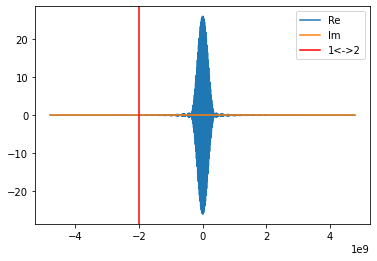

In [10]:
omegapoints = np.arange(-num_samples // 2, num_samples // 2).astype(float) * 2. * np.pi / pulse_seq.duration
frequency_domain = np.roll(fft(time_domain), num_samples // 2)
plt.plot(omegapoints, frequency_domain.real, label='Re')
plt.plot(omegapoints, frequency_domain.imag, label='Im')
q0 = hgen.qudit_params('q0')
plt.axvline(q0.anharmonicity, color='red', label='1<->2')
plt.legend();

In [11]:
# approximate the Gaussian with a triangle -> area = Heff * duration / 2
# pi/2 = (nu_X/test_amp*amp * duration / 2)
rough_amp_estimate = np.pi / 2. / (res01_components[1] / test_amplitude * duration_01 / 2.)
rough_amp_estimate

0.13193276586929956

In [12]:
amplitudes = rough_amp_estimate * np.linspace(0.8, 1.2, 20)
pulses = list(qudit_sim.pulse.Gaussian(duration=duration_01, amp=amp, sigma=sigma_01) for amp in amplitudes)

hgens = hgen.make_scan('amplitude', pulses, qudit_id='q0', frequency=drive_frequency_01)

tlist = {'points_per_cycle': 10, 'duration': duration_01}

sim_results = qudit_sim.pulse_sim(hgens, tlist=tlist, final_only=True)

components_list = np.array(qudit_sim.apps.gates.gate_components(sim_results, comp_dim=3))

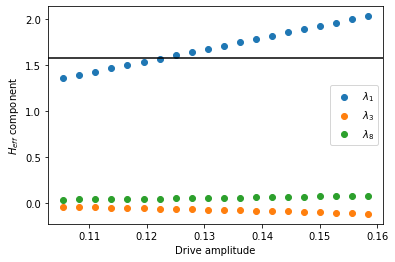

In [13]:
for i in [1, 3, 8]:
    plt.scatter(amplitudes, components_list[:, i], label=fr'$\lambda_{i}$')
plt.axhline(np.pi / 2., color='black')
plt.xlabel('Drive amplitude')
plt.ylabel('$H_{eff}$ component')
plt.legend();

Gaussian amplitude at which the X component hits $\pi/2$:

In [14]:
line = lambda x, slope, intercept: slope * x + intercept
popt, _ = sciopt.curve_fit(line, amplitudes, components_list[:, 1], p0=(0., 0.))

best_amplitude_01 = (np.pi / 2. - popt[1]) / popt[0]
best_amplitude_01

0.12250982970504341

Run the Gaussian pulse simulation again with this amplitude:

In [15]:
hgen.clear_drive()
pulse = qudit_sim.pulse.Gaussian(duration=duration_01, amp=best_amplitude_01, sigma=sigma_01)
hgen.add_drive('q0', frequency=drive_frequency_01, amplitude=pulse)
sim_result = qudit_sim.pulse_sim(hgen, tlist=tlist, final_only=True)
best_01_gaus_components = qudit_sim.apps.gates.gate_components(sim_result, comp_dim=3)

In [16]:
qudit_sim.visualization.print_components(best_01_gaus_components, scale='pi')

<IPython.core.display.Latex object>

In [17]:
qudit_sim.visualization.print_components(best_01_gaus_components, scale='pi', basis='qudit')

<IPython.core.display.Latex object>

## DRAG pulse

The two-quadrature control (DRAG) can be used to create gate pulses that satisfy certain constraints. Here we aim to create a qubit X pulse, which means the phase error must be cast onto $\ket{2}$ alone, i.e., eliminate the $\lambda_3$ term.

References:

- Motzoi, Gambetta, Rebentrost, Wilhelm. "Simple pulses for elimination of leakage in weakly nonliear qubits", Phys. Rev. Lett., 103, 110501 (2009).
- Gambetta, Motzoi, Merkel, Wilhelm. "Analytic control methods for high-fidelity unitary operations in a weakly nonlinear oscillator", Phys. Rev. A, 83, 012308 (2011).

In [18]:
hgen.clear_drive()

beta_guess = -0.5 / hgen.qudit_params('q0').anharmonicity
betas = np.linspace(0.5 * beta_guess, 2. * beta_guess, 20)
pulses = list(qudit_sim.pulse.Drag(duration=duration_01, amp=best_amplitude_01, sigma=sigma_01, beta=beta) for beta in betas)

hgens = hgen.make_scan('amplitude', pulses, qudit_id='q0', frequency=drive_frequency_01)

sim_results = qudit_sim.pulse_sim(hgens, tlist=tlist, final_only=True)

components_list = np.array(qudit_sim.apps.gates.gate_components(sim_results, comp_dim=3))

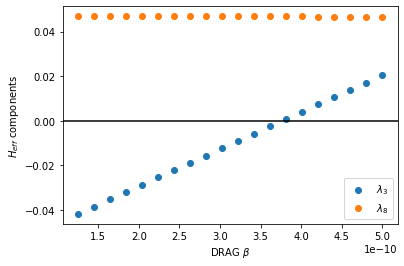

In [19]:
for i in [3, 8]:
    plt.scatter(betas, components_list[:, i], label=fr'$\lambda_{i}$')
plt.axhline(0., color='black')
plt.xlabel(r'DRAG $\beta$')
plt.ylabel('$H_{eff}$ components')
plt.legend();

$\beta$ parameter that eliminates $Z_{01}$:

In [20]:
popt, _ = sciopt.curve_fit(line, betas, components_list[:, 3], p0=(0., 0.))

best_beta_01 = (0. - popt[1]) / popt[0]
best_beta_01

3.768248977184241e-10

Running the full DRAG pulse simulation:

In [21]:
hgen.clear_drive()
pulse = qudit_sim.pulse.Drag(duration=duration_01, amp=best_amplitude_01, sigma=sigma_01, beta=best_beta_01)
hgen.add_drive('q0', frequency=drive_frequency_01, amplitude=pulse)
sim_result = qudit_sim.pulse_sim(hgen, tlist=tlist, final_only=True)
best_01_drag_components = qudit_sim.apps.gates.gate_components(sim_result, comp_dim=3)

In [22]:
qudit_sim.visualization.print_components(best_01_drag_components, scale='pi')

<IPython.core.display.Latex object>

## $\pi$ pulse for $\ket{1}\leftrightarrow\ket{2}$ transition

Let's go through the same exercise for $\ket{1} \leftrightarrow \ket{2}$.

In [23]:
hgen.clear_drive()

drive_frequency_12 = hgen.dressed_frequencies('q0')[1]
test_amplitude = 0.2

init = dict((i, (0., True)) for i in [1, 2, 4, 5, 11, 12, 13, 14])

res12_components = qudit_sim.apps.find_heff(hgen, qudit='q0', frequency=drive_frequency_12, amplitude=test_amplitude,
                                            cycles=200, optimizer_args=0.001, convergence=1.e-6, comp_dim=3,
                                            init=init, save_result_to='pi_pulse/res12')

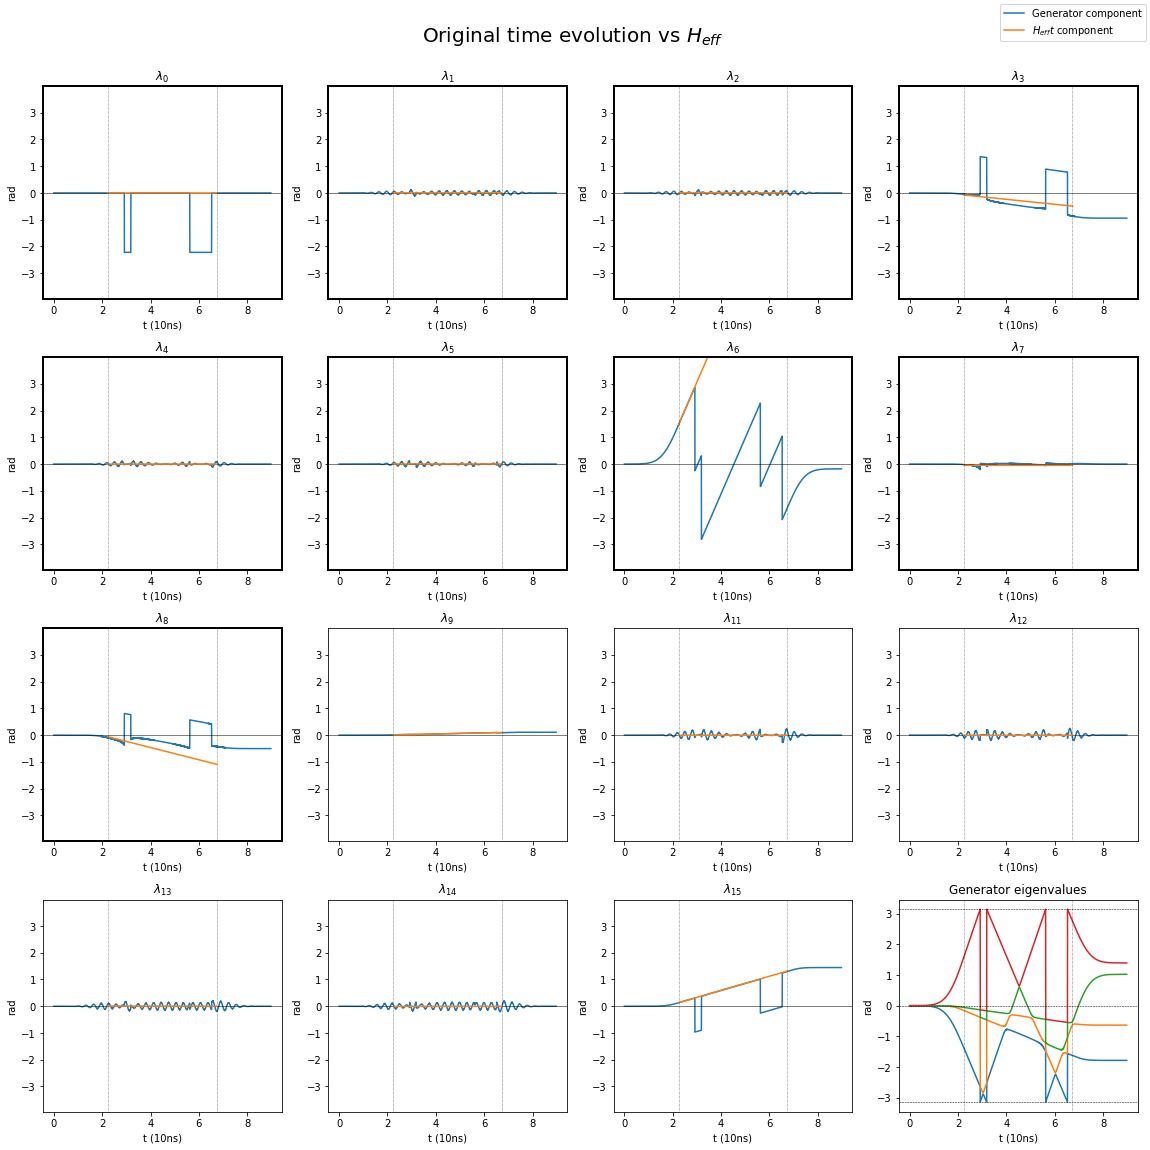

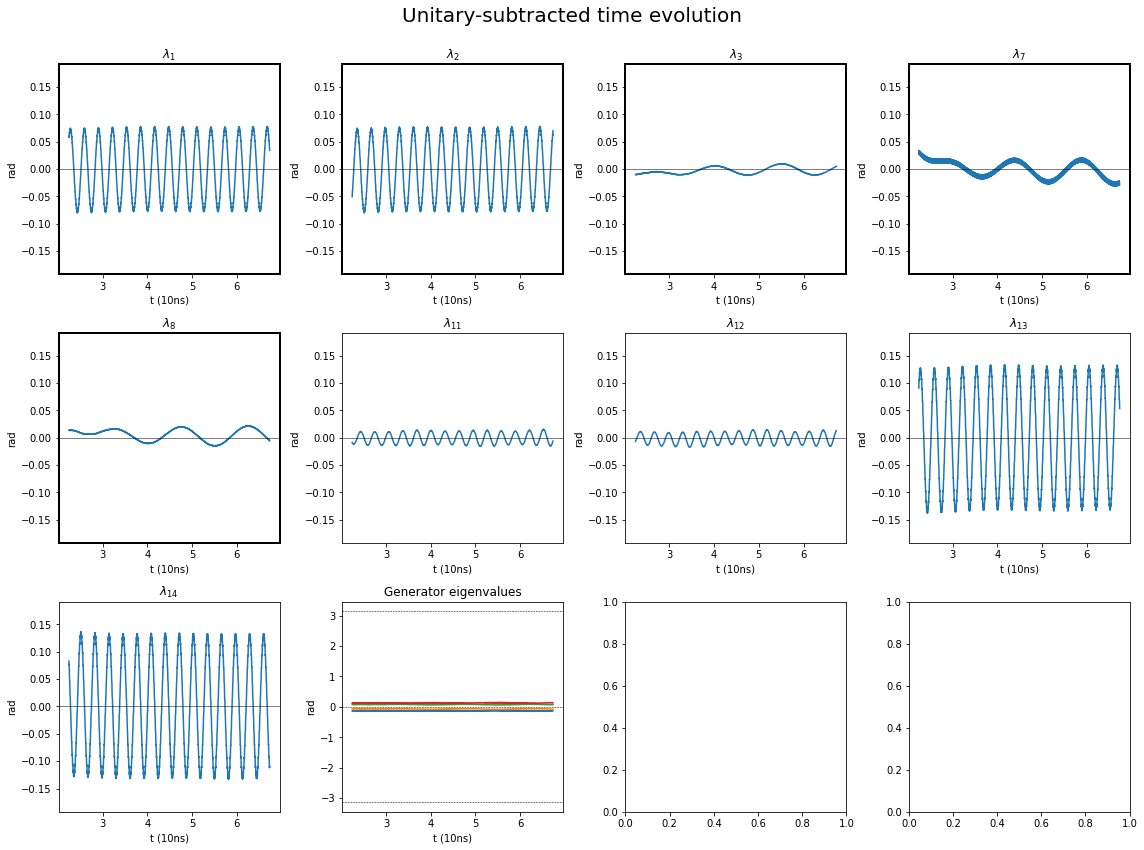

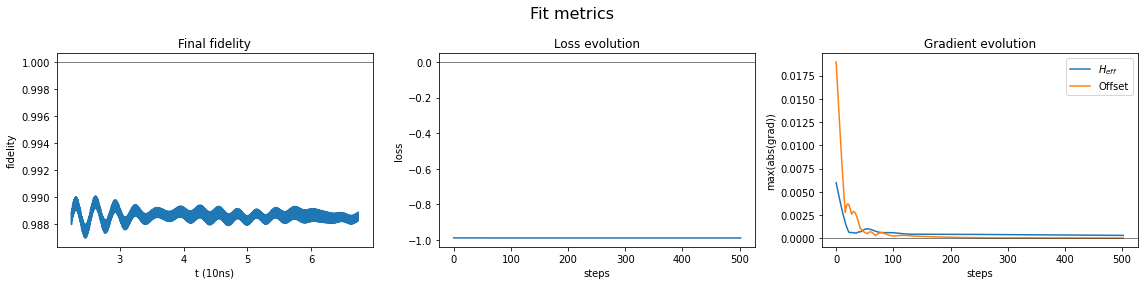

In [24]:
qudit_sim.visualization.inspect_heff_fit('pi_pulse/res12.h5');

In [25]:
qudit_sim.visualization.print_components(res12_components)

<IPython.core.display.Latex object>

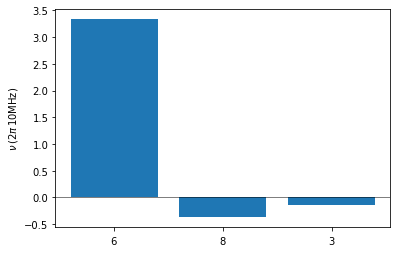

In [26]:
qudit_sim.visualization.plot_components(res12_components);

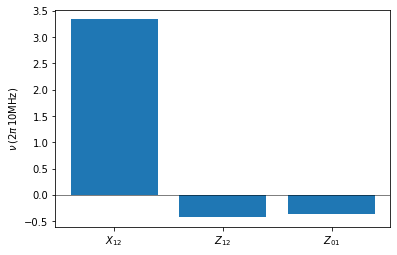

In [27]:
qudit_sim.visualization.plot_components(res12_components, basis='qudit');

In [28]:
duration_12 = unit_time * 160
sigma_12 = unit_time * 40

hgen.clear_drive()

# approximate the Gaussian with a triangle -> area = amp * duration / 2.
rough_amp_estimate = np.pi / 2. / (res12_components[6] / test_amplitude * duration_12 / 2.)

amplitudes = rough_amp_estimate * np.linspace(0.8, 1.2, 20)
pulses = list(qudit_sim.pulse.Gaussian(duration=duration_12, amp=amp, sigma=sigma_12) for amp in amplitudes)

hgens = hgen.make_scan('amplitude', pulses, qudit_id='q0', frequency=drive_frequency_12)

tlist = {'points_per_cycle': 10, 'duration': duration_12}

sim_results = qudit_sim.pulse_sim(hgens, tlist=tlist, final_only=True)
components_list = np.array(qudit_sim.apps.gates.gate_components(sim_results, comp_dim=3))

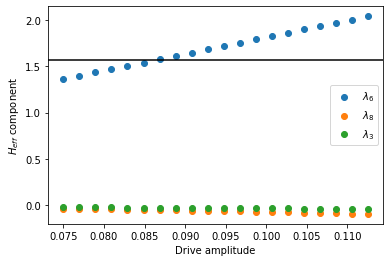

In [29]:
for i in [6, 8, 3]:
    plt.scatter(amplitudes, components_list[:, i], label=fr'$\lambda_{i}$')
plt.axhline(np.pi / 2., color='black')
plt.xlabel('Drive amplitude')
plt.ylabel('$H_{eff}$ component')
plt.legend();

In [30]:
popt, _ = sciopt.curve_fit(line, amplitudes, components_list[:, 6], p0=(0., 0.))

best_amplitude_12 = (np.pi / 2. - popt[1]) / popt[0]
best_amplitude_12

0.0866097677998436

In [31]:
hgen.clear_drive()
pulse = qudit_sim.pulse.Gaussian(duration=duration_12, amp=best_amplitude_12, sigma=sigma_12)
hgen.add_drive('q0', frequency=drive_frequency_12, amplitude=pulse)
sim_result = qudit_sim.pulse_sim(hgen, tlist=tlist, final_only=True)
best_12_gaus_components = qudit_sim.apps.gates.gate_components(sim_result, comp_dim=3)

In [32]:
qudit_sim.visualization.print_components(best_12_gaus_components, scale='pi')

<IPython.core.display.Latex object>

In [33]:
qudit_sim.visualization.print_components(best_12_gaus_components, scale='pi', basis='qudit')

<IPython.core.display.Latex object>

Next we calibrate the DRAG to eliminate $\mathrm{diag}(0, 1, -1) = \frac{\sqrt{3}}{2} \lambda_8 - \frac{1}{2} \lambda_3$.

In [34]:
hgen.clear_drive()

beta_guess = -0.5 / hgen.qudit_params('q0').anharmonicity
betas = np.linspace(0.5 * beta_guess, 2. * beta_guess, 20)
pulses = list(qudit_sim.pulse.Drag(duration=duration_12, amp=best_amplitude_12, sigma=sigma_12, beta=beta) for beta in betas)

hgens = hgen.make_scan('amplitude', pulses, qudit_id='q0', frequency=drive_frequency_12)

sim_results = qudit_sim.pulse_sim(hgens, tlist=tlist, final_only=True)

components_list = np.array(qudit_sim.apps.gates.gate_components(sim_results, comp_dim=3))
components_list = qudit_sim.change_basis(components_list, to_basis='pauli1', num_qudits=1).real

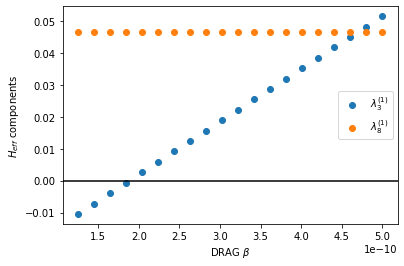

In [35]:
for i in [3, 8]:
    plt.scatter(betas, components_list[:, i], label=fr'$\lambda^{{(1)}}_{i}$')
plt.axhline(0., color='black')
plt.xlabel(r'DRAG $\beta$')
plt.ylabel('$H_{eff}$ components')
plt.legend();

In [36]:
popt, _ = sciopt.curve_fit(line, betas, components_list[:, 3], p0=(0., 0.))

best_beta_12 = (0. - popt[1]) / popt[0]
best_beta_12

1.8811487650783666e-10

Running the full DRAG pulse simulation:

In [37]:
hgen.clear_drive()
pulse = qudit_sim.pulse.Drag(duration=duration_12, amp=best_amplitude_12, sigma=sigma_12, beta=best_beta_12)
hgen.add_drive('q0', frequency=drive_frequency_12, amplitude=pulse)
sim_result = qudit_sim.pulse_sim(hgen, tlist=tlist, final_only=True)
best_12_drag_components = qudit_sim.apps.gates.gate_components(sim_result, comp_dim=3)

In [38]:
qudit_sim.visualization.print_components(best_12_drag_components, scale='pi', basis='pauli1')

<IPython.core.display.Latex object>

$\pi$ pulse identification is actually automated in `apps.gates.pi_pulse`. This function directly constructs a DRAG pulse through numerical optimization (and is thus less instructive than this exercise):

In [39]:
drive_frequency, pi_pulse = qudit_sim.apps.gates.pi_pulse(hgen, 'q0', 1, duration_12, sigma_12)
print(pi_pulse)

Drag(duration=3.2e-08, amp=(0.08655908640850309+0j), sigma=8e-09, beta=1.9500691356495498e-10, center=1.6e-08, zero_ends=True)


In [41]:
hgen.clear_drive()
hgen.add_drive('q0', frequency=drive_frequency, amplitude=pi_pulse)
tlist = hgen.make_tlist(8, duration=pi_pulse.duration)
sim_result = qudit_sim.pulse_sim(hgen, tlist=tlist, final_only=True, log_level=logging.INFO)
components = qudit_sim.apps.gates.gate_components(sim_result, comp_dim=3)
qudit_sim.visualization.print_components(components, scale='pi', basis='pauli1')

INFO:qudit_sim.pulse_sim:Using 2364 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 0.687679 seconds.


<IPython.core.display.Latex object>